In [24]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import random
import torch


#check all the files in the input dataset
print(os.listdir("../deeplearning/archive/"))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [25]:
random.seed(1)
torch.manual_seed(1)

In [8]:
#choosing DOM_hourly.csv data for analysis
fpath='../deeplearning/archive/DOM_hourly.csv'
df=pd.read_csv(fpath)
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116189 entries, 0 to 116188
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  116189 non-null  object 
 1   DOM_MW    116189 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [10]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [11]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

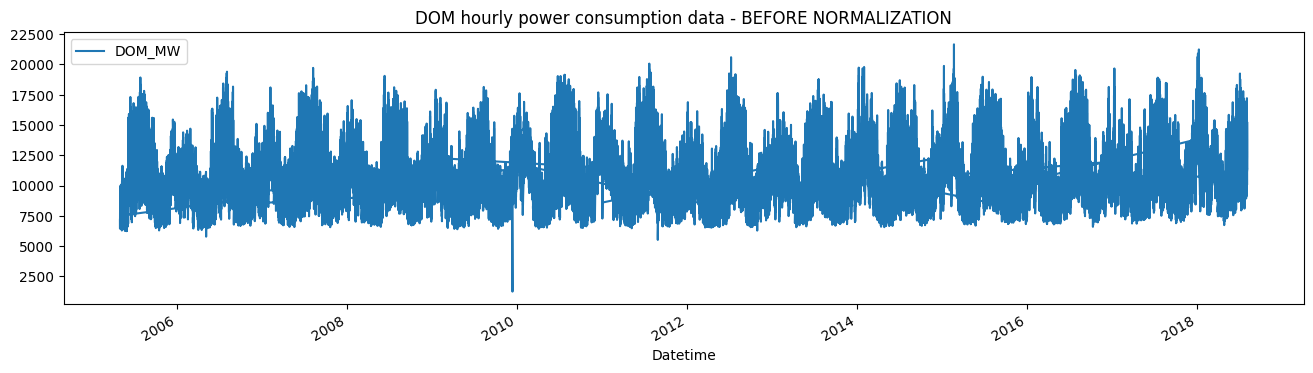

In [12]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [13]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

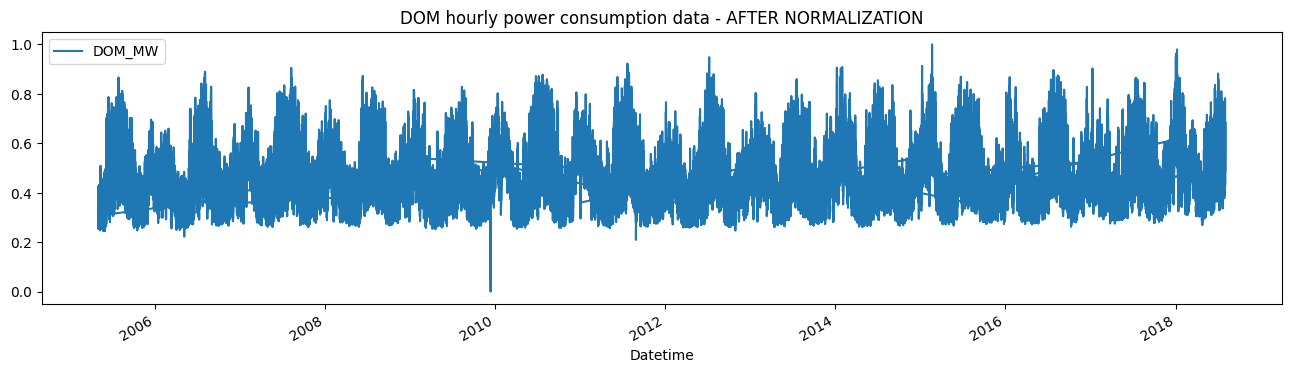

In [14]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [15]:
df_norm.shape

(116189, 1)

In [16]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [17]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [18]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

d:\Python\AllProject\DeepLearning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201 (32.04 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.2575
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0345
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0156
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0104
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0079
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0064
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0054
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0046
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0042
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0037


In [27]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R2 Score of RNN model =  0.9442765841465499


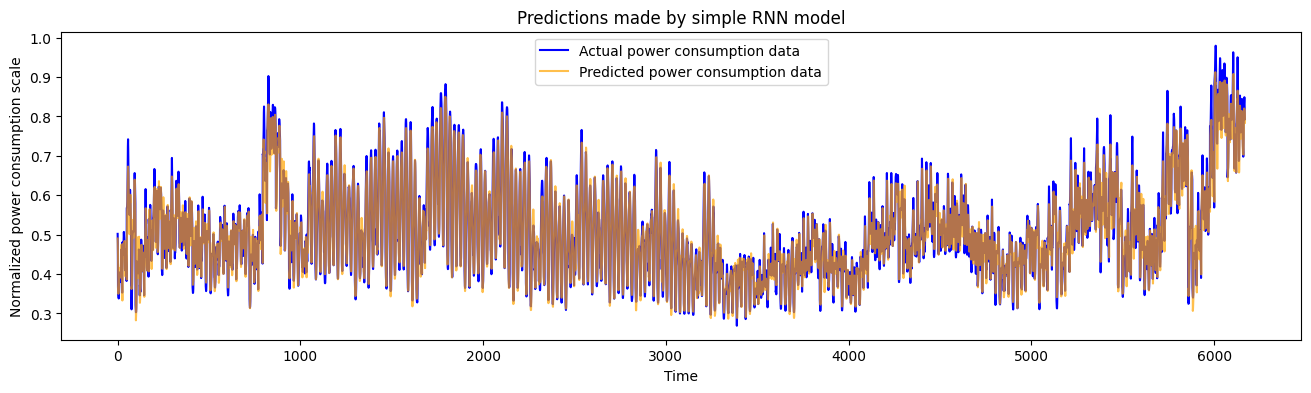

In [28]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")